In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyogo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tyogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tyogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'xgboost'

In [2]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', sep=',').dropna()
combined_data = combined_data.drop_duplicates().reset_index(drop=True)
# combined_data = pd.read_csv('./Gambling-Online-Promotion-Detection/Dataset/dataset_combined_feb_2.csv', sep='\t')#.dropna()

training_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv', sep=',').dropna()
testing_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv', sep=',').dropna()
validation_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv').dropna()

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [3]:
print(training_data['text'].isna().sum())
print(testing_data['text'].isna().sum())
print(validation_data['text'].isna().sum())

0
0
0


In [4]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421 entries, 0 to 3420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3421 non-null   object
 1   label   3421 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.6+ KB


In [5]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

# lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        # text = text.lower()

        # text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        # word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [6]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
texts_raw_validation = validation_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_test = testing_data['label'].values.copy()
y_val = validation_data['label'].values.copy()

In [7]:
texts_train = preprocess_text(texts_raw_train)
texts_test = preprocess_text(texts_raw_test)
texts_validation = preprocess_text(texts_raw_validation)
texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

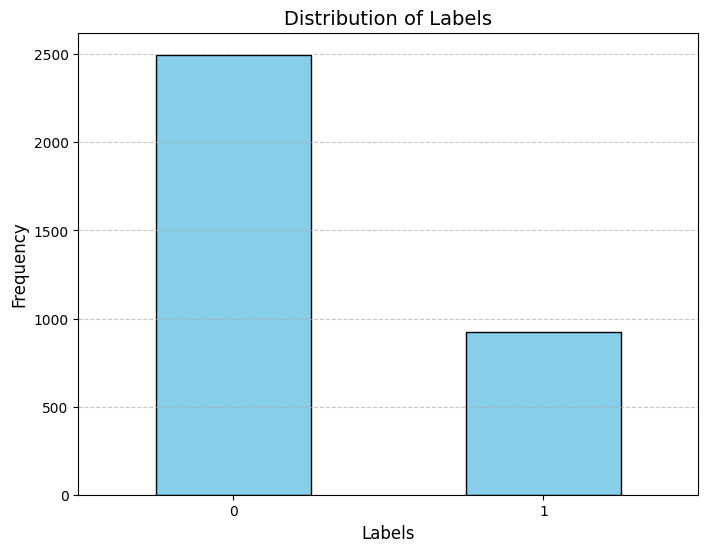

In [8]:
label_counts = combined_data['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [9]:
texts = combined_data['text'].values
labels = combined_data['label'].values
texts = preprocess_text(texts)

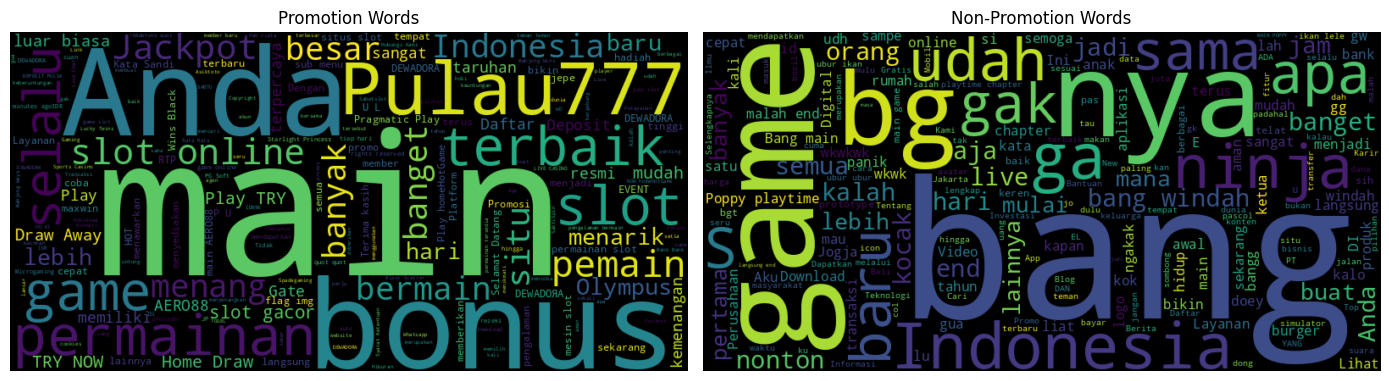

In [10]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the texts by class
promotion_texts = texts[labels == 1]
non_promotion_texts = texts[labels == 0]

# Generate wordcloud for each class
promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(promotion_texts))
non_promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_promotion_texts))

# Plot the wordclouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(promotion_wordcloud, interpolation='bilinear')
axes[0].set_title("Promotion Words")
axes[0].axis("off")

axes[1].imshow(non_promotion_wordcloud, interpolation='bilinear')
axes[1].set_title("Non-Promotion Words")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize_function(texts_train.tolist())
test_encodings = tokenize_function(texts_test.tolist())
validation_encodings = tokenize_function(texts_validation.tolist())

model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=2, from_pt=True)

epochs = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=(
        [validation_encodings['input_ids'], validation_encodings['attention_mask']], 
        y_val
    ),
    batch_size=16,
    epochs=epochs,
    class_weight=class_weights,  # Apply class weights
    callbacks=[checkpoint_callback]
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

I0000 00:00:1746607353.199055      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


I0000 00:00:1746607389.876204     100 service.cc:148] XLA service 0x7f1810e01b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746607389.876657     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746607389.950454     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746607390.078510     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9404
Epoch 1: val_accuracy improved from -inf to 0.97668, saving model to ./checkpoint
171/171 [==============================] - 239s 1s/step - loss: 0.1582 - accuracy: 0.9404 - val_loss: 0.0712 - val_accuracy: 0.9767
Epoch 2/2
171/171 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9934
Epoch 2: val_accuracy improved from 0.97668 to 0.97959, saving model to ./checkpoint
171/171 [==============================] - 194s 1s/step - loss: 0.0252 - accuracy: 0.9934 - val_loss: 0.0799 - val_accuracy: 0.9796


11/11 [==============================] - 11s 671ms/step
Accuracy Score: 0.9853801169590644
Classification Report:               precision    recall  f1-score   support

NotPromotion       0.98      1.00      0.99       250
   Promotion       0.99      0.96      0.97        92

    accuracy                           0.99       342
   macro avg       0.99      0.98      0.98       342
weighted avg       0.99      0.99      0.99       342

Confusion Matrix:



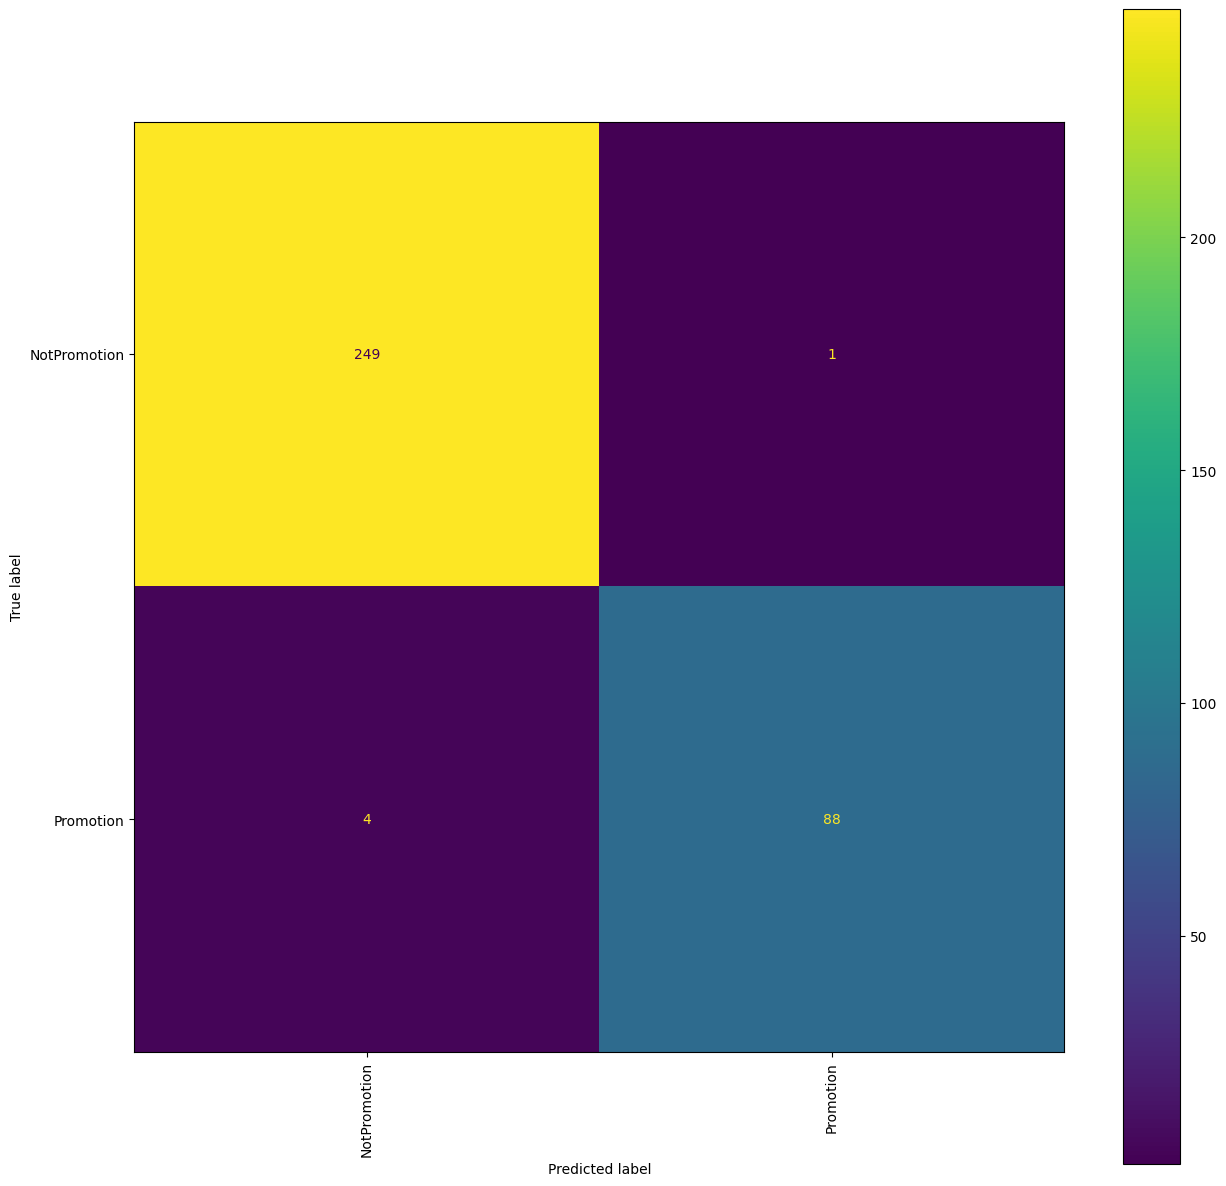

In [12]:
pred = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

softmax_probs = tf.nn.softmax(pred.logits, axis=1).numpy()  # shape: (num_samples, 2)

# Take the probability of class 1
prob_class_1 = softmax_probs[:, 1]

# Apply threshold of 0.5
pred_labels = [1 if p >= 0.97 else 0 for p in prob_class_1]

print(f"Accuracy Score: {accuracy_score(pred_labels, y_test)}")
print(f"Classification Report: {classification_report(y_test, pred_labels, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_labels), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [13]:
def predict_sentiment(text):
    use_text = preprocess_text(text)
    encoding = tokenize_function(use_text)
    pred = model.predict([encoding['input_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
 
    pred_labels = [label_type[i] for i in pred_labels.numpy().tolist()]
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")

In [14]:
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar."
]
predict_sentiment(text)

1/1 [==============================] - 5s 5s/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: NotPromotion
Gacor xxtoto menang dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: Promotion
gacor menang xxtoto: Promotion
top up kantorbola gampang menangnya: Promotion
gratis koin buruan topup agencasinoindonesia: Promotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: Promotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 dibayar ? gabung Menang berapapun dibayar .: Promotion


In [15]:
model.save_pretrained('judol_detection_model')

In [16]:
model.save('judol_detection_models')

In [17]:
combined_data.to_csv('output.csv', index=False) 

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9888
Recall: 0.9565
F1-score: 0.9724


In [19]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, pred_labels, average='weighted', beta=0.5)

0.985349334773807